# Experiment to compare different Keras optimizer.

In [1]:
# load the mltb lib - see here: https://github.com/PhilipMay/mltb
!pip install mltb==0.0.10

In [2]:
import mltb
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.


In [3]:
# load MNIST data
(train_images, train_labels), (val_images, val_labels) = mnist.load_data()

In [4]:
# show shape of data
print("train_images.shape:", train_images.shape)
print("train_labels.shape:", train_labels.shape)
print("val_images.shape:", val_images.shape)
print("val_labels.shape:", val_labels.shape)

train_images.shape: (60000, 28, 28)
train_labels.shape: (60000,)
val_images.shape: (10000, 28, 28)
val_labels.shape: (10000,)


In [5]:
# one hot encode the labels
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)

In [6]:
# flatten the data so we can send it to dense layer
train_images = train_images.reshape((60000, 28 * 28))
val_images = val_images.reshape((10000, 28 * 28))

In [7]:
# normalization (min-max scaling) to 0 to 1
train_images = train_images.astype('float32') / 255
val_images = val_images.astype('float32') / 255

In [8]:
#network with BatchNormalization and without bias (use_bias=False)
def network():
    network = models.Sequential()
    network.add(layers.Dense(100, use_bias=False, input_shape=(28 * 28,)))
    network.add(layers.BatchNormalization())
    network.add(layers.Activation('relu'))
    network.add(layers.Dense(100, use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.Activation('relu')) 
    network.add(layers.Dense(100, use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.Activation('relu'))
    network.add(layers.Dense(10, activation='softmax'))
    return network

In [9]:
# print summary representation of network
network().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10000     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10000     
__________

In [10]:
# create the different networks, fit them and return results
def fit(value):
    _network = network()
        
    _network.compile(optimizer=value,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
 
    es = EarlyStopping(monitor='val_acc', patience=5, mode='max')
    
    history = _network.fit(train_images, train_labels, 
                          validation_data=(val_images, val_labels), 
                          epochs=100, 
                          callbacks=[es],
                          verbose=0,
                          batch_size=128)
    
    best_val_acc = max(history.history['val_acc'])
    
    best_val_acc_epoch = history.history['val_acc'].index(best_val_acc) + 1
    
    return {'best_val_acc' : best_val_acc, 'best_val_acc_epoch' : best_val_acc_epoch}

In [11]:
# dict with call params
param_dict = {'Adam' : 'adam', 
              'Adamax' : 'adamax', 
              'Nadam' : 'nadam', 
             }

# fit the networks many times and return the result
# see here: https://github.com/PhilipMay/mltb/blob/master/mltb/tools.py
result = mltb.tools.multi_param_call(fit, param_dict, 31)

Done with Adam - iteration 1 of 1.
Done with Adamax - iteration 1 of 1.
Done with Nadam - iteration 1 of 1.


In [12]:
#print the result
print(result)

{'best_val_acc': {'Adam': [0.9796], 'Adamax': [0.98], 'Nadam': [0.9792]}, 'best_val_acc_epoch': {'Adam': [9], 'Adamax': [6], 'Nadam': [13]}}


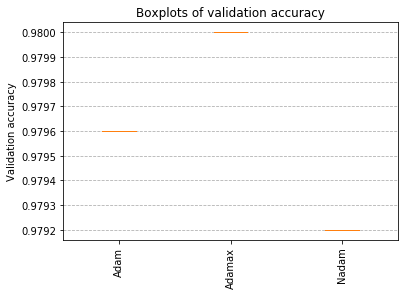

In [13]:
# print boxplots to compare validation accuracy of both results 
# see here: https://github.com/PhilipMay/mltb/blob/master/mltb/plot.py
mltb.plot.boxplot_dict(result['best_val_acc'], 
                       ylabel='Validation accuracy', 
                       title='Boxplots of validation accuracy'
                      )

In [14]:
# p-value for validation accuracy - can we reject the null hypothesis?
# see here: https://github.com/PhilipMay/mltb/blob/master/mltb/tools.py
print('p-value for best_val_acc:', mltb.tools.ttest_combinations(result['best_val_acc']))

p-value for best_val_acc: {('Adam', 'Adamax'): nan, ('Adam', 'Nadam'): nan, ('Adamax', 'Nadam'): nan}


/usr/local/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


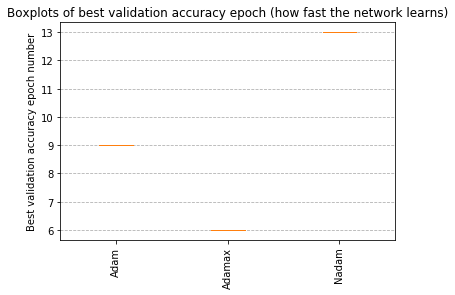

In [15]:
# print boxplots to compare wich epoch had the best validation accuracy (how fast the network learns)
# see here: https://github.com/PhilipMay/mltb/blob/master/mltb/plot.py
mltb.plot.boxplot_dict(result['best_val_acc_epoch'], 
                       ylabel='Best validation accuracy epoch number', 
                       title='Boxplots of best validation accuracy epoch (how fast the network learns)'
                      )

In [16]:
# p-value for best validation accuracy epoch - can we reject the null hypothesis?
# see here: https://github.com/PhilipMay/mltb/blob/master/mltb/tools.py
print('p-value for best_val_acc_epoch:', mltb.tools.ttest_combinations(result['best_val_acc_epoch']))

p-value for best_val_acc_epoch: {('Adam', 'Adamax'): nan, ('Adam', 'Nadam'): nan, ('Adamax', 'Nadam'): nan}
